# 1. Introduction

In professional rugby, as in many sports, the identification of Key Performance Indicators (KPIs) is crucial for understanding and improving team performance. The identification of KPIs associated with successful match outcomes enables coaches, performance analysts, and players to inform and refine tactical decision-making, optimize playing strategies, and tailor physical conditioning programs based on quantifiable metrics. The integration of data in decision-making processes facilitates the development of more effective training interventions and match tactics, potentially enhancing overall team performance ([Colomer & al. 2020](../bibliography/Colomer%20&%20al.%20(2020).pdf)). 

Recent studies have employed advanced data analysis techniques, particularly random forest models, to identify key performance indicators (KPIs) in rugby union. Random forest is a machine learning algorithm that constructs multiple decision trees and merges them to get a more accurate and stable prediction. [Bennett et al. (2018](../bibliography/Bennett%20&%20al.%20(2018).pdf), [2020](../bibliography/Bennett%20&%20al.%20(2020).pdf)) analyzed the English Premiership and Rugby World Cup, while [Scott et al. (2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [2023b](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)) examined the United Rugby Championship and international women's rugby matches. These studies identified common KPIs across different leagues and levels of play, including meters gained, kicks from hand, clean breaks, and turnovers.

In these analyses, researchers have explored two main approaches to KPI measurement: isolated and relative. Isolated indicators consider a team's performance metrics independently, while relative indicators measure the difference in performance between opposing teams. For example, an isolated KPI would be the total carries meters gained by each team within a match, whereas the relative KPI would be the difference in carries meters gained between the team and their opponent. Relative indicators are theoretically more pertinent as they capture, to some extent, the dynamics of opposition. This approach corresponds to the complex, interactive nature of rugby, where team performance is intrinsically linked to the actions of the opponent. However, this perceived superiority of relative indicators remains a matter of debate within the field. While [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf) and [Scott et al. (2023a)](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), have demonstrated enhanced predictive accuracy of match outcomes, others, including [Scott et al. (2023b)](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf) have found no significant difference in predictive power between the two approaches.

While identifying KPIs is crucial for optimizing the probability of winning, their practical application is equally essential. If KPIs are too numerous and complex to interpret, they are unlikely to enable coaches and performance staff to make informed decisions that maximize the chances of success. Major data providers offer numerous PIs across various dimensions of rugby play, but such large groups can be complex to interpret and implement. To address this, recent studies have emphasized statistically optimizing PI selection with reduced datasets. [Scott et al. (2023a)](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf) demonstrated that feature selection can simplify models without degrading prediction accuracy. The feature selection of the most relevant PIs enhances model interpretability and enables coaches to make informed decisions based on concise, actionable insights. By focusing on a streamlined set of key PIs, coaches can prioritize critical areas for improving team performance and communicate strategies more effectively to players and staff.

Despite the proliferation of studies identifying match outcome predictors in various rugby competitions, a significant gap exists in the literature regarding France's Top 14, one of Europe's premier rugby leagues. This gap is particularly noteworthy given the unique characteristics of the Top 14, especially in terms of home advantage. Home advantage, defined as home teams winning over 50% of games in a balanced schedule ([Courneya & Carron, 1992](../bibliography/Courneya%20&%20Carron%20(1992).pdf)), is a well-established phenomenon in sports, including rugby. [Vaz et al. (2012)](../bibliography/Vaz%20&%20al.%20(2012).pdf) demonstrated that home teams in rugby benefit from advantages in several key performance areas, including penalty goals, rucks/mauls won, and passes completed. Furthermore, [Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf) reported a home win percentage of 64.4% in the Top 14 between 2014 and 2019, significantly higher than other major rugby leagues such as the English Premiership, Mitre 10 Cup, and Pro14 (56.9% combined) or the Currie Cup (42.9%). This substantial difference in home advantage across leagues suggests that the competitive dynamics in the Top 14 may differ from other competitions. Consequently, the relative importance of various performance indicators could vary between the Top 14 and other leagues.

Given this context, the primary aim of the current study is to identify and reduce PIs that maximize prediction accuracy of match outcomes from relative data sets, in Top 14 league. Additionally, we aim to evaluate the predictive capacity of a model based on these indicators and examine the impact of home advantage on both model performance and individual performance indicators.


In [2]:
# Import the necessary libraries
import sys
sys.path.append('..')
import joblib
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from statsmodels.stats.contingency_tables import mcnemar
from IPython.display import Markdown, display

from src.data_processing import *
from src.database_utils import *

# ----------------------------------------------------------------------------------------------------------------------
# Get number of physical cores, to improve the computation time of ML algorithms.
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 16


c:\Users\hans9\.conda\envs\data_analysis-env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hans9\.conda\envs\data_analysis-env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# 2. Methodology

## 2.1. Preprocessing

### 2.1.1. Data Source and Extraction

The data for this study was extracted from a comprehensive rugby statistics database, publicly available on GitHub ([rugby-data-scraper](https://github.com/hans-brgs/rugby-data-scraper)). The database was constructed by scraping data from the ESPN website, with OPTA as the primary provider. The GitHub repository contains detailed information on the [scraping methodology](https://github.com/hans-brgs/rugby-data-scraper?tab=readme-ov-file#overview-of-the-etl-process), [database architecture](https://github.com/hans-brgs/rugby-data-scraper/tree/main/database#summary-of-architectural-choices), and a [data dictionary defining each KPI](https://github.com/hans-brgs/rugby-data-scraper/tree/main/dictionary#readme).
The data used in this study is consistent with key studies in the field, including [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf), [Scott et al. (2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [2023b)](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf), which also relied on OPTA data. This consistency ensures reliability and allows for meaningful comparisons with other major studies.
Although no published reliability analysis exists specifically for OPTA's Rugby Union data, studies have demonstrated high inter-operator reliability of OPTA data in football, with kappa values ranging from 0.92 to 0.94 ([Scott et al., 2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [Liu & al. 2013](../bibliography/Liu%20&%20al.%20(2013).pdf)). Given OPTA's reputation and widespread use, we have confidence in the quality and accuracy of the dataset.
A subset of the full database was extracted into a CSV file : "[rugby_data.csv](../database/rugby_data.csv)", containing the relevant variables for our analysis. This focused dataset allows for a targeted investigation of specific research questions. However, the complete database hosted on GitHub is far more extensive and can be leveraged for a wide range of additional research projects.


In [3]:
# Load database
with open("../database/rugby_data.csv", "r") as f :
	data_df = pd.read_csv(f)


### 2.1.2. Filtering data

The dataset underwent several pre-processing steps to ensure data quality and relevance to the research objectives. Firstly, the analysis was limited to data from the French Top 14 league between the 2017 and 2023 seasons. This choice was made in order to strike a balance between a sufficient volume of data for a solid analysis and the inclusion of recent seasons reflecting the current dynamics of the game. This choice considers the potential impact of rule changes on the importance of key performance indicators (KPIs). For instance, [Strydom et al. (2024)](../bibliography/Strydom%20&%20al.%20(2024).pdf) demonstrated that the introduction of the 50:22 kick law in 2022 significantly altered kicking strategies in South African rugby, with an increase in kicks by scrum-halves (from 20% to 26%, p = 0.00) and a decrease in kicks by fullbacks (from 21% to 18%, p = 0.01). This evolution underscores the importance of analyzing recent data to capture the current state of the game and the influence of regulatory changes on the relative importance of KPIs on match outcomes.

Data from the 2019-2020 and 2020-2021 seasons were excluded due to COVID-19 disruptions. The 2019-2020 season was cancelled after the 17th matchday ([Ungureanu et al., 2021](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)), out of the 26 days that make up a full season, while the 2020-2021 season was played without spectators, reducing home wins by 10.8% ([Ungureanu et al., 2021](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)). Additionally, playoff matches from each season were excluded as they occur on neutral grounds, mitigating typical home advantage effects ([Nevill & Holder, 1999](../bibliography/Nevill%20&%20Holder%20(1999).pdf) ; [Nevill & al., 2002](../bibliography/Nevill%20&%20al.%20(2002).pdf)). This exclusion ensures the analyzed data represent typical match conditions.


In [4]:
# Filter data by removing 2020 and 2021 season
filtered_data_df = data_df[~data_df['season'].isin([2020, 2021])]

# Filter data by exluding playoff matches
regular_seasons_df = exclude_playoff(filtered_data_df)

### 2.1.3. Selection of key performance indicators

Our database contains over 70 isolated key performance indicators (KPIs) across five dimensions of rugby play: Play, Defensive, Set Piece, Discipline, and Play Control. To ensure a focused analysis aligned with current literature, we selected 27 general KPIs based on previous studies, particularly [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf) and [Scott et al. (2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [2023b)](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf).
The chosen KPIs cover essential aspects of rugby performance, including runs, clean breaks, offloads, defenders beaten, carries metres, tackles, turnovers, lineouts, scrums, rucks, penalties, and disciplinary actions. We also incorporated additional metrics such as mauls and ball collection statistics to provide a comprehensive analysis of Top 14 league performance.
This selection balances consistency with existing research and the introduction of new insights. Table 1 provides a detailed comparison of our KPIs with those used in previous studies.


**Table 1. Comparison of KPI selection between studies**
| Bennett et al. (2018)                         | Scott et al. (2023) A      | Scott et al. (2023) B      | Our analysis (General KPIs)            |
| --------------------------------------------- | -------------------------- | -------------------------- | -------------------------------------- |
| Carries made                                  | Carries                    | Carries                    | Runs                                   |
| Clean breaks                                  | Clean breaks               | Clean breaks               | Clean breaks                           |
| Offloads                                      | Offloads                   | Offloads                   | Offload                                |
| Total number of defenders beaten              | Defenders beaten           | Defenders beaten           | Defenders beaten                       |
| Total number of metres ball was carried       | Metres made                | Meters made                | Carries metres                         |
| Tackles made                                  | Tackles                    | Tackles                    | -                                      |
| Tackles missed                                | Missed tackles             | Missed tackles             | Missed tackles                         |
| Ratio tackles missed to tackles made          | -                          | -                          | Tackle success                         |
| Turnovers a team won                          | Turnovers won              | Turnovers won              | Turnover won                           |
| Turnovers a team conceded                     | Turnovers conceded         | Turnovers conceded         | Turnovers conceded                     |
| Lineout throws won on own ball                | Lineouts won               | Lineouts won               | Lineouts won                           |
| Lineout throws lost on own ball               | Lineouts lost              | Lineouts lost              | Lineouts lost                          |
| The number of kicks from hand                 | Kicks from hand            | Kicks from hand            | Kick from hand metres                  |
| Penalties conceded offence (with the ball)    | Penalties conceded         | Penalties conceded         | Penalties conceded                     |
| Penalties conceded defence (without the ball) | -                          | -                          | -                                      |
| The average distance for each ball carry      | -                          | -                          | -                                      |
| -                                             | Passes                     | Passes                     | Passes                                 |
| -                                             | Scrums won                 | Scrums won                 | Scrums won                             |
| -                                             | Scrums lost                | Scrums lost                | Scrums lost                            |
| -                                             | Rucks won                  | Rucks won                  | Rucks won                              |
| -                                             | Rucks lost                 | Rucks lost                 | Rucks lost                             |
| -                                             | Free kicks                 | Free kicks                 | Total free kicks conceded              |
| -                                             | Scrum penalties            | Scrum penalties            | -                                      |
| -                                             | Lineout penalties          | Lineout penalties          | -                                      |
| -                                             | Tackle/ruck/maul penalties | Tackle/ruck/maul penalties | -                                      |
| -                                             | General play penalties     | General play penalties     | -                                      |
| -                                             | Control penalties          | Control penalties          | -                                      |
| -                                             | Yellow cards               | Yellow cards               | Yellow cards                           |
| -                                             | Red cards                  | Red cards                  | Red cards                              |
| -                                             | Home/away status           | -                          | Home/away status                       |
| -                                             | -                          | -                          | Mauls won                              |
| -                                             | -                          | -                          | Mauls lost                             |
| -                                             | -                          | -                          | Mauling metres                         |
| -                                             | -                          | -                          | Collection failed                      |
| -                                             | -                          | -                          | Collection success                     |
| **TOTAL**                                     | **TOTAL**                  | **TOTAL**                  | **TOTAL**                              |
| 16                                            | 27                         | 26                         | 27                                     |



> ✅ <span style="color:blue">**Note**</span> ✅ <br>
> For clarification on any KPI, refer to our [KPI dictionary](https://github.com/hans-brgs/rugby-data-scraper/blob/main/dictionary/README.md).

> ✅ <span style="color:blue">**Note for Customization**</span> ✅ <br>
> Users can modify the `config/kpi.json` file to select specific KPIs of interest for their own analyses. This flexibility allows for tailored research approaches while maintaining the structural integrity of the analysis process.

In [5]:

# Loading KPIs from the configuration file
with open("../config/kpi.json", "r") as f:
	kpis = json.load(f)
	
# Extracting general KPIs
general_kpi = kpis["general"]
all_general_kpi = [el for key in general_kpi.keys() for values in general_kpi[key].values() for el in values]

# Add additional descriptive feature that will aid in processing and analyzing the data
descriptive_features = kpis["descriptive"]

# Selecting KPIs for the analysis (only general KPIs)
full_kpi_features = all_general_kpi

# We included the 'isHome' feature in our set of performance indicators.
full_kpi_features = full_kpi_features + ["isHome"]
# And we remove it from the descriptive features to avoid redundancy.
descriptive_features.remove("isHome")

selected_features = (descriptive_features + full_kpi_features)

### --- If you want to select all KPIs for analysis, uncomment the following lines ---
# Extracting detailed KPIs (not used in this analysis)		   
# detailled_kpi = kpis["detailled"]
# all_detailled_kpi = [el for key in detailled_kpi.keys() for values in detailled_kpi[key].values() for el in values]

# full_kpi_features = (all_general_kpi + all_detailled_kpi) 
# selected_features = (descriptive_data + full_kpi_features)

# Filter data by keeping only selected features
regular_seasons_df = regular_seasons_df[selected_features]

### 2.1.4. Data Quality Assessment

To ensure data integrity and completeness, a comprehensive quality assessment was conducted on the dataset. This process involved three key steps:

- Quantification of total matches per season.
- Identification of matches with missing data.
- Removal of all data associated with incomplete matches.

Table 02 presents a summary of this analysis, detailing the number of complete and incomplete matches per season. Table 03 provides a comprehensive list of matches excluded from the dataset due to missing data.

In [6]:
# Count total rows per season
total_matches  = regular_seasons_df.groupby('season').size().reset_index(name='count')

test = regular_seasons_df.dropna()

# Count rows without missing data
complete_matches  = regular_seasons_df.dropna().groupby('season').size().reset_index(name='count')
missing_matches = regular_seasons_df[regular_seasons_df.isna().any(axis=1)]

# Remove missing data
regular_seasons_without_na_df = regular_seasons_df.dropna().reset_index()

# Merge and calculate statistics
match_stats = total_matches
match_stats["unique_matches"] = match_stats["count"] // 2
match_stats["matches_without_missing"] = complete_matches["count"] // 2
match_stats["missing_matches"] = match_stats["unique_matches"] - match_stats['matches_without_missing']

#-------------------------------------------------------------------------------------------------------------------------------------------------------

### MARKDOWN 

# convert df to markdown
match_stats_md = match_stats.to_markdown(index=False)
missing_matches_md = missing_matches[["season", "matchName", "matchDate"]].to_markdown(index=False)

# Text markdown
markdown_text = f"""
**Table 02. Summary of data qualtity assessment**
{match_stats_md}
- The `unique_matches` column represents the total number of matches analyzed per season.
- The `missing_matches` column indicates how many matches have incomplete data in each season.<br>

The results show that each season consistently includes 182 unique matches, which is the expected number for the Top 14 competition, 
according to [Top 14 Wikipedia](https://en.wikipedia.org/wiki/Top_14). Each team plays 26 matches during the regular season. 
With 14 teams in the league, this gives 182 unique matches per season (14 teams * 26 matches / 2), confirming that our database is complete in terms of match quantity.

**Table 03. List of missing data**
{missing_matches_md}

The majority of the seasons included in the analyses (2017, 2018, 2022, 2023 and 2024), present complete data for all 182 matches. However, for the 2019 season, 7 matches have missing data.
When we analyze the missing data, we observe that these data correspond to matches on the first day of the 2017 season.
"""

display(Markdown(markdown_text))


**Table 02. Summary of data qualtity assessment**
|   season |   count |   unique_matches |   matches_without_missing |   missing_matches |
|---------:|--------:|-----------------:|--------------------------:|------------------:|
|     2017 |     364 |              182 |                       182 |                 0 |
|     2018 |     364 |              182 |                       182 |                 0 |
|     2019 |     364 |              182 |                       175 |                 7 |
|     2022 |     364 |              182 |                       182 |                 0 |
|     2023 |     364 |              182 |                       182 |                 0 |
|     2024 |     364 |              182 |                       182 |                 0 |
- The `unique_matches` column represents the total number of matches analyzed per season.
- The `missing_matches` column indicates how many matches have incomplete data in each season.<br>

The results show that each season consistently includes 182 unique matches, which is the expected number for the Top 14 competition, 
according to [Top 14 Wikipedia](https://en.wikipedia.org/wiki/Top_14). Each team plays 26 matches during the regular season. 
With 14 teams in the league, this gives 182 unique matches per season (14 teams * 26 matches / 2), confirming that our database is complete in terms of match quantity.

**Table 03. List of missing data**
|   season | matchName                                | matchDate           |
|---------:|:-----------------------------------------|:--------------------|
|     2019 | Montpellier Herault vs Castres Olympique | 2018-08-26 15:05:00 |
|     2019 | Montpellier Herault vs Castres Olympique | 2018-08-26 15:05:00 |
|     2019 | Toulon vs Racing 92                      | 2018-08-25 18:45:00 |
|     2019 | Toulon vs Racing 92                      | 2018-08-25 18:45:00 |
|     2019 | Bordeaux Begles vs Pau                   | 2018-08-25 15:15:00 |
|     2019 | Bordeaux Begles vs Pau                   | 2018-08-25 15:15:00 |
|     2019 | Clermont Auvergne vs Agen                | 2018-08-25 15:15:00 |
|     2019 | Clermont Auvergne vs Agen                | 2018-08-25 15:15:00 |
|     2019 | Lyon vs Stade Toulousain                 | 2018-08-25 15:15:00 |
|     2019 | Lyon vs Stade Toulousain                 | 2018-08-25 15:15:00 |
|     2019 | La Rochelle vs Grenoble                  | 2018-08-25 15:15:00 |
|     2019 | La Rochelle vs Grenoble                  | 2018-08-25 15:15:00 |
|     2019 | Perpignan vs Stade Francais Paris        | 2018-08-25 12:45:00 |
|     2019 | Perpignan vs Stade Francais Paris        | 2018-08-25 12:45:00 |

The majority of the seasons included in the analyses (2017, 2018, 2022, 2023 and 2024), present complete data for all 182 matches. However, for the 2019 season, 7 matches have missing data.
When we analyze the missing data, we observe that these data correspond to matches on the first day of the 2017 season.



### 2.1.5. Processing Relative Performance Indicators

This study employed relative performance indicators rather than isolated PI data for model construction.

Relative data were derived by computing the difference in each PI between opposing teams for each match. For instance, if Team A gained 200 meters and Team B gained 400 meters, the relative data would be -200 meters for Team A and +200 meters for Team B (see table 04), as opposed to the isolated values of 200 and 400 meters (see table 05), respectively.

The use of relative data is supported by a growing body of evidence in rugby performance analysis. [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf) reported that models using relative data achieved higher predictive accuracy (80%) compared to those using isolated data (64% accuracy). Similarly, [Scott et al. (2023a)](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf) found that relative data models correctly classified 85% of match outcomes, outperforming isolated data models (66% accuracy).
The superior performance of relative data in predictive modeling is attributed to its ability to contextualize performance by capturing the dynamics of opposition. This approach aligns with the complex, interactive nature of rugby, where team performance is intrinsically linked to the actions of the opponent.

However, it is important to note that the superiority of relative indicators remains a topic of debate in the field. While [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf) and [Scott et al. (2023a)](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf) demonstrated enhanced predictive accuracy of match outcomes using relative data, [Scott et al. (2023b)](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf) found no significant difference in predictive power between relative and isolated approaches in their analysis of international women's rugby matches.

Despite this ongoing debate, the potential benefits of relative data in capturing the interactive nature of rugby performance led to its adoption in this study.

In [7]:
# Calculate relative statistics
regular_seasons_relative_df = calculate_relative_stats(regular_seasons_without_na_df, full_kpi_features, descriptive_features)

#-------------------------------------------------------------------------------------------------------------------------------------------------------

### Check data Integrity
# Select columns to display
columns_to_show = ['season', 'matchDate', 'teamName', 'opponentTeamName', 'passes', 'offload', 'cleanBreaks']

# Create markdown text
markdown_text = f"""
**Table 04. Example of isolated data sample**
{regular_seasons_df.sort_values('matchEspnId').loc[:, columns_to_show].head(2).to_markdown(index=False)}

**Table 05. Example of relative data sample**
{regular_seasons_relative_df.sort_values('matchEspnId').loc[:, columns_to_show].head(2).to_markdown(index=False)}

**Note:** The relative data shows the difference between each team's performance and their opponent's for the selected metrics. 
Positive values indicate a superior performance to that of the opponent for a given measure, and vice versa.
"""
# Display the markdown
display(Markdown(markdown_text))


**Table 04. Example of isolated data sample**
|   season | matchDate           | teamName   | opponentTeamName   |   passes |   offload |   cleanBreaks |
|---------:|:--------------------|:-----------|:-------------------|---------:|----------:|--------------:|
|     2017 | 2016-08-21 16:15:00 | Toulon     | Bayonne            |      126 |        18 |            14 |
|     2017 | 2016-08-21 16:15:00 | Bayonne    | Toulon             |      105 |         8 |            11 |

**Table 05. Example of relative data sample**
|   season | matchDate           | teamName   | opponentTeamName   |   passes |   offload |   cleanBreaks |
|---------:|:--------------------|:-----------|:-------------------|---------:|----------:|--------------:|
|     2017 | 2016-08-21 16:15:00 | Toulon     | Bayonne            |       21 |        10 |             3 |
|     2017 | 2016-08-21 16:15:00 | Bayonne    | Toulon             |      -21 |       -10 |            -3 |

**Note:** The relative data shows the difference between each team's performance and their opponent's for the selected metrics. 
Positive values indicate a superior performance to that of the opponent for a given measure, and vice versa.


### 2.1.6. Match Outcome Classification

The dataset contained match scores but lacked explicit categorization of outcomes as wins or losses. Therefore, a binary classification process was implemented to derive match outcomes from the score data. Matches were classified as wins (1) or losses (0) based on the final score differential (see table 06).

Drawn matches were excluded from the dataset to ensure a clear binary classification and maintain consistency with previous studies in the field ([Bennett et al., 2018](../bibliography/Bennett%20&%20al.%20(2018).pdf); [Scott et al., 2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [2023b](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)). However, it is acknowledged that this approach may slightly limit the model's applicability to real-world scenarios where drawn matches do occur, albeit infrequently in the Top 14 competition.

In [8]:

# Step 1 : count draw match 
number_of_draw_matches = len(regular_seasons_relative_df[regular_seasons_relative_df['scoreDiff'] == 0])
total_matches = len(regular_seasons_relative_df)

# Step 2 : drop draw match
regular_seasons_relative_without_draw_df = regular_seasons_relative_df.drop(regular_seasons_relative_df[regular_seasons_relative_df['scoreDiff'] == 0].index)

# Step 3 : win / lose classification
conditions = [
    (regular_seasons_relative_without_draw_df['scoreDiff'] > 0),  # Condition 1: score_diff > 0
    (regular_seasons_relative_without_draw_df['scoreDiff'] < 0),  # Condition 2: score_diff < 0
]
choices = [True, False]

# Create the 'is_winner' column with numpy.select
regular_seasons_relative_without_draw_df['isWinner'] = np.select(conditions, choices, default=np.nan)

#-------------------------------------------------------------------------------------------------------------------------------------------------------

### Check data Integrity
# Select columns to display
columns_to_show = ['season', 'matchDate', 'teamName', 'opponentTeamName', 'teamScore', 'opponentTeamScore', 'isWinner']

# Create markdown text
markdown_text = f"""
**Drawn Match Statistics**

- Total matches in dataset: {total_matches}
- Number of drawn matches: {number_of_draw_matches}
- Percentage of drawn matches: {(number_of_draw_matches/total_matches*100):.2f}%

The relatively low percentage of drawn matches ({(number_of_draw_matches/total_matches*100):.2f}%) suggests that their exclusion is unlikely to significantly impact our analysis.

**Table 06. Sample of the processed dataset, illustrating the binary classification of match outcomes.**
{regular_seasons_relative_without_draw_df.sort_values("matchEspnId").loc[:, columns_to_show].head(2).to_markdown(index=False)}

"""
# Display the markdown
display(Markdown(markdown_text))


**Drawn Match Statistics**

- Total matches in dataset: 2170
- Number of drawn matches: 62
- Percentage of drawn matches: 2.86%

The relatively low percentage of drawn matches (2.86%) suggests that their exclusion is unlikely to significantly impact our analysis.

**Table 06. Sample of the processed dataset, illustrating the binary classification of match outcomes.**
|   season | matchDate           | teamName   | opponentTeamName   |   teamScore |   opponentTeamScore |   isWinner |
|---------:|:--------------------|:-----------|:-------------------|------------:|--------------------:|-----------:|
|     2017 | 2016-08-21 16:15:00 | Toulon     | Bayonne            |          23 |                  28 |          0 |
|     2017 | 2016-08-21 16:15:00 | Bayonne    | Toulon             |          28 |                  23 |          1 |



## 2.2. Model Configuration and Training

In this study, we employed Random Forest Classification (RFC) to analyze the relative Performance Indicators (PIs) and categorize match outcomes as wins or losses. RFC, developed by [Breiman (2001)](../bibliography/Breiman%20(2001).pdf), is an ensemble learning method designed to enhance the classification and regression performance of decision trees (CART) by aggregating predictions from a multitude of individual decision trees.
In our model, each of the 27 relative Performance Indicators (PIs) represents a feature in the RFC. The RFC algorithm systematically interrogates the feature space formed by these PIs across all considered matches to generate ensemble decisions, ultimately classifying each match outcome.

The RFC process operates as follows:
- RF builds many binary classification trees (`n_estimators`) using several bootstrap samples with replacements drawn from the originalobservations.
- At each node of these trees, a given number of input features (`max_features`, corresponding to the square root of the total number of input features) are randomly chosen for splitting, introducing variability among the trees.
- The final classification is determined by aggregating the votes from all the trees in the forest, with each tree contributing one vote for the most frequent class.

### 2.2.1. Optimizing the Number of Estimators

The first step in our model configuration process is to determine the optimal number of estimators (decision trees) for our RFC (see figure 01).

1. **Estimator Range**:
   - We tested a range of estimators from 1 to 500, incrementing by 25.
   - This wide range allows us to observe the model's performance across varying levels of complexity.

2. **Cross-Validation Setup**:
   - We employed 5-fold stratified cross-validation to ensure robust performance estimation across different subsets of our data.
   - This approach helps mitigate overfitting and provides a more reliable estimate of model performance.

3. **Performance Metric**:
   - We used accuracy as our primary performance metric, which is appropriate for our balanced binary (our two classes : lose/win are roughly equally represented in the dataset) classification task.

4. **Stability Analysis**:
   - We implemented a custom function (`mean_threshold_detection`) to identify the point at which the model's performance stabilizes.

In [9]:
# Feature preparation
X = regular_seasons_relative_without_draw_df[full_kpi_features]
y = regular_seasons_relative_without_draw_df["isWinner"]

# Range of estimators to test
n_estimators = list(range(1, 90, 10)) + list(range(100, 500, 25))

# Cross-validation and scoring
results = []
for n in n_estimators :
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy", cv=StratifiedKFold(5), n_jobs= int(N_CORES/2))
    results.append({
        'n_estimators': n,
        'mean_score': np.mean(scores),
        'std_score': np.std(scores)
    })

# Convertir les résultats en DataFrame
scores_df = pd.DataFrame(results)

**Figure 1. Relationship between the number of estimators and the model accuracy.**

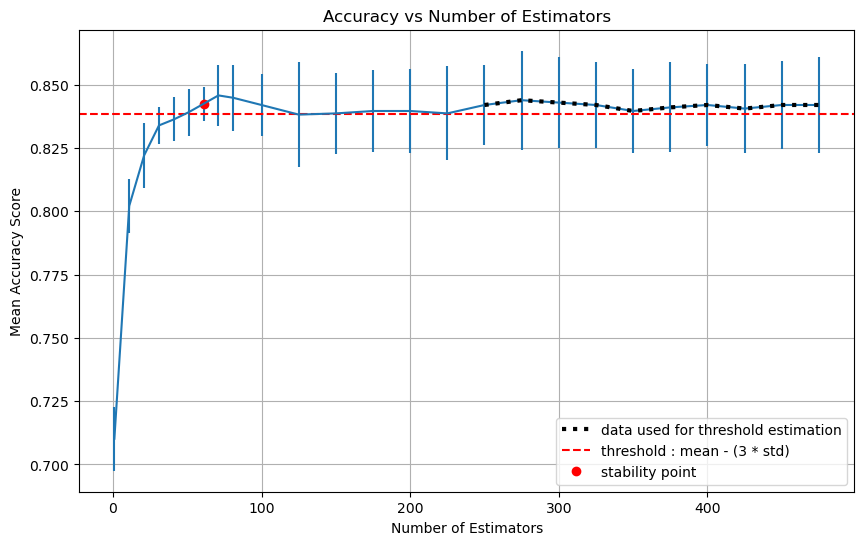



1. The model's performance generally improves as the number of estimators increases.
2. The performance stabilizes after a certain point, indicated by the red dot on the graph.
3. The optimal number of estimators is **61**, achieving an accuracy of **0.8425**.

**Note** : This analysis allows us to select an efficient model configuration that balances computational cost with predictive performance. 
In subsequent analyses, we will use this optimal number of estimators to train our final model and determine the key predictors of rugby match outcomes.


In [10]:

# Stability point detection
flat_curve_start_idx = -10
flat_curve_end_idx = None
stable_point_idx, thr = mean_threshold_detection(scores_df['mean_score'], flat_curve_start_idx, flat_curve_end_idx, window_size=3)

stable_point_val = scores_df['mean_score'][stable_point_idx]
optimal_estimators = scores_df['n_estimators'][stable_point_idx]

# Visualization
plt.figure(figsize=(10,6))
plt.plot(scores_df['n_estimators'][flat_curve_start_idx : flat_curve_end_idx], 
		 scores_df['mean_score'][flat_curve_start_idx: flat_curve_end_idx], 
		 ":k", label="data used for threshold estimation", linewidth=3, zorder=5)
plt.errorbar(scores_df['n_estimators'], scores_df['mean_score'], yerr=scores_df['std_score'])
plt.axhline(y = thr, linestyle="--", color="r", label="threshold : mean - (3 * std)")
plt.plot(optimal_estimators, stable_point_val, "or", label="stability point")
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.grid(True)
plt.legend()
display(Markdown("**Figure 1. Relationship between the number of estimators and the model accuracy.**"))
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""

1. The model's performance generally improves as the number of estimators increases.
2. The performance stabilizes after a certain point, indicated by the red dot on the graph.
3. The optimal number of estimators is **{optimal_estimators}**, achieving an accuracy of **{stable_point_val:.4f}**.

**Note** : This analysis allows us to select an efficient model configuration that balances computational cost with predictive performance. 
In subsequent analyses, we will use this optimal number of estimators to train our final model and determine the key predictors of rugby match outcomes.
"""
# Display the markdown
display(Markdown(markdown_text))

---

# 3. Résultats

## 3.1. Identification of key performance indicator of match outcomes
To identify the most significant predictors of match outcomes in Top 14 rugby, we employed three feature selection methods: **Recursive Feature Elimination with Cross-Validation (RFECV)**, **Random Forest Classifier Feature Importance**, and **Permutation Importance**.

### 3.1.1. Recursive Feature Elimination with Cross-Validation (RFECV)
RFECV was utilized to determine the optimal number of features while maintaining model performance. This method starts with all features and iteratively removes the least important ones, evaluating model performance at each step using cross-validation. The process continues until the optimal number of features is identified, based on model accuracy. It's important to note that RFECV does not provide a ranking of importance among the selected features. The method focuses on identifying the optimal subset of features for model performance, rather than ordering them by importance within that subset. The selected features should be considered as a collective set that optimizes the model's performance, without implying a specific order of importance among them.


In [11]:
# Initialize the Random Forest Classifier with optimal number of estimators
rf = RandomForestClassifier(n_estimators=optimal_estimators, random_state=42)

# Set the number of cross-validation folds
fold = 5

# Initialize RFECV (Recursive Feature Elimination with Cross-Validation)
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(fold),
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=int(N_CORES//2),
)
# Fit RFECV to the data
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=np.int64(61),
                                       random_state=42),
      n_jobs=8, scoring='accuracy')

In [12]:
# Extract number of features and corresponding mean and std accuracy scores
n_features = rfecv.cv_results_["n_features"]  
mean_score = rfecv.cv_results_["mean_test_score"]  
std_score = rfecv.cv_results_["std_test_score"]

# Set parameters for identifying the stabilization point
flat_curve_start_idx = -15
flat_curve_end_idx = None

# Identify the stabilization point using a customized threshold stabilization detection function.
stable_point_id, thr = mean_threshold_detection(mean_score, flat_curve_start_idx, flat_curve_end_idx, 5)

# Find the maximum accuracy and its corresponding index
max_accuracy_id = np.argmax(mean_score)
max_accuracy_val = np.max(mean_score)

# Calculate 95% Confidence Intervals for stable point and max accuracy
CI_stable_point_accuracy = stats.t.interval(confidence=0.95, df=fold-1, loc=mean_score[stable_point_id], scale=std_score[stable_point_id]/np.sqrt(fold))
CI_max_accuracy = stats.t.interval(confidence=0.95, df=fold-1, loc=mean_score[max_accuracy_id], scale=std_score[max_accuracy_id]/np.sqrt(fold))

# Perform Recursive Feature Elimination with the optimal number of features
rfe = RFE(estimator=rf, n_features_to_select=n_features[stable_point_id])
rfe.fit(X, y)


RFE(estimator=RandomForestClassifier(n_estimators=np.int64(61),
                                     random_state=42),
    n_features_to_select=np.int64(9))

**Figure 2. RFECV - Relationship between the number of features and the model's accuracy in predicting rugby match outcomes**

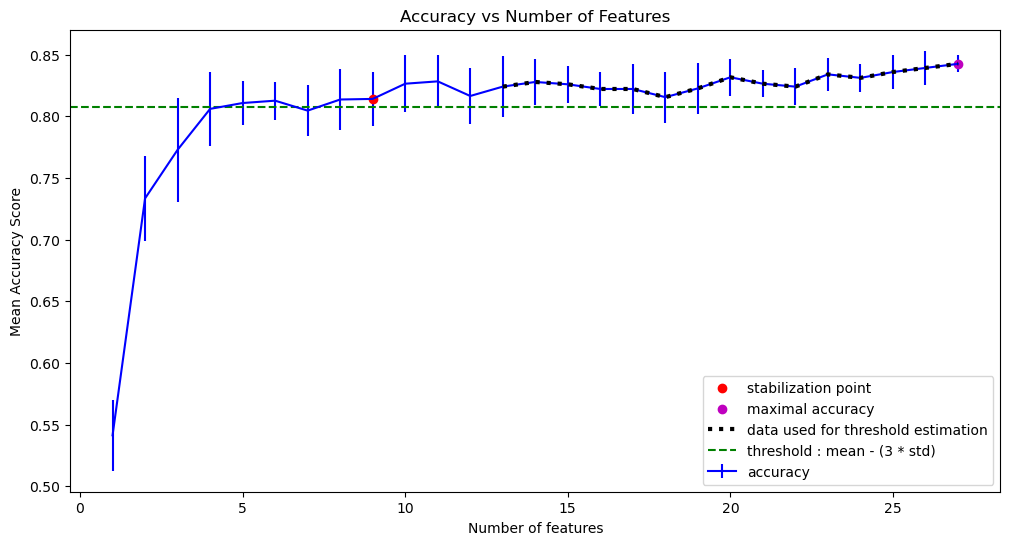



1. **Rapid initial increase**: Accuracy improves quickly with the first few features added, rising from about 0.54 to 0.81 with only 5 features.

2. **Performance Plateau**: After about 9 features, 
accuracy score stabilizes around 0.814 (81%), with minor fluctuation. 
Notably, while our algorithm identifies the plateau at 9 features, 
the average accuracy between 5 and 9 features does not significantly increase.

3. **Diminishing Returns**: Adding features beyond this point only marginally improves accuracy, suggesting a good trade-off between model complexity and performance. 
However, the accuracy and 95% confidence interval for the stabilization point accuracy 
(acc = 0.814, CI95%[0.79, 0.84]) 
overlaps little with that of the maximum accuracy obtained using all features (acc=0.843,  CI95%[0.83, 0.85]).
Moreover, the standard deviation at the point of maximum accuracy is the lowest, indicating reduced variance and increased robustness of the model at this point.

**Summary** : although the performance plateau is technically identified at 9 features, the improvement between 5 and 9 features is not significant. 
Nevertheless, the minimal overlap of the confidence intervals and the reduced standard deviation at 
the point of maximum accuracy suggest that retaining all features might be tempting to optimize the model's accuracy.

**Choice** : The features retained are the 9 features identified by our algorithm (table 07). 
This selection balances high accuracy and reduced complexity, making the model more interpretable and efficient for practical use.

**Table 07. Features retained by RFECV**
|    | selected features   |
|---:|:--------------------|
|  0 | passes              |
|  1 | cleanBreaks         |
|  2 | carriesMetres       |
|  3 | kickFromHandMetres  |
|  4 | rucksWon            |
|  5 | maulingMetres       |
|  6 | turnoversConceded   |
|  7 | tackleSuccess       |
|  8 | isHome              |



In [13]:

plt.figure(figsize = (12, 6))
plt.errorbar(n_features, mean_score, yerr=std_score, color='b', linestyle='-', label="accuracy")
plt.plot(n_features[stable_point_id], mean_score[stable_point_id], 'ro', label="stabilization point")
plt.plot(n_features[max_accuracy_id], mean_score[max_accuracy_id], 'mo', label="maximal accuracy")
plt.plot(n_features[flat_curve_start_idx : flat_curve_end_idx], mean_score[flat_curve_start_idx : flat_curve_end_idx], ":k", label="data used for threshold estimation", linewidth=3, zorder=5)
plt.axhline(y=thr, color='g', linestyle='--' ,label="threshold : mean - (3 * std)")
plt.xlabel('Number of features')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs Number of Features')
plt.legend()
display(Markdown("**Figure 2. RFECV - Relationship between the number of features and the model's accuracy in predicting rugby match outcomes**"))
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""

1. **Rapid initial increase**: Accuracy improves quickly with the first few features added, rising from about {mean_score[0]:.2f} to {mean_score[4]:.2f} with only 5 features.

2. **Performance Plateau**: After about {n_features[stable_point_id]} features, 
accuracy score stabilizes around {mean_score[stable_point_id]:.3f} ({mean_score[stable_point_id] * 100:.0f}%), with minor fluctuation. 
Notably, while our algorithm identifies the plateau at {n_features[stable_point_id]} features, 
the average accuracy between 5 and {n_features[stable_point_id]} features does not significantly increase.

3. **Diminishing Returns**: Adding features beyond this point only marginally improves accuracy, suggesting a good trade-off between model complexity and performance. 
However, the accuracy and 95% confidence interval for the stabilization point accuracy 
(acc = {mean_score[stable_point_id]:.3f}, CI95%[{CI_stable_point_accuracy[0]:.2f}, {CI_stable_point_accuracy[1]:.2f}]) 
overlaps little with that of the maximum accuracy obtained using all features (acc={mean_score[-1]:.3f},  CI95%[{CI_max_accuracy[0]:.2f}, {CI_max_accuracy[1]:.2f}]).
Moreover, the standard deviation at the point of maximum accuracy is the lowest, indicating reduced variance and increased robustness of the model at this point.

**Summary** : although the performance plateau is technically identified at 9 features, the improvement between 5 and 9 features is not significant. 
Nevertheless, the minimal overlap of the confidence intervals and the reduced standard deviation at 
the point of maximum accuracy suggest that retaining all features might be tempting to optimize the model's accuracy.

**Choice** : The features retained are the 9 features identified by our algorithm (table 07). 
This selection balances high accuracy and reduced complexity, making the model more interpretable and efficient for practical use.

**Table 07. Features retained by RFECV**
{pd.DataFrame(rfe.get_feature_names_out()).rename(columns={0: "selected features"}).to_markdown()}

"""
# Display the markdown
display(Markdown(markdown_text))



### 3.1.2. Random Forest Classifier Feature Importance

The Random Forest Classifier Feature Importance method assesses feature importance based on the average impurity reduction brought by each feature across all trees in the random forest. This measure indicates how much each feature contributes to decreasing the weighted impurity in a tree. Features that result in larger decreases are considered more important. 

### 3.1.3 Permutation Feature Importance
Permutation Importance measures the decrease in model performance when the values of a feature are randomly permuted. In this context, "randomly permuted" means that the values of a specific feature are shuffled randomly across different observations, thus breaking any potential relationship between this feature and the target variable (in our case, the match outcome).
A feature is considered more important if its random permutation results in a larger decrease in model performance. This implies that the model relies heavily on this feature for accurate predictions. Conversely, if permuting a feature's values leads to little or no change in model performance, it suggests that the feature is less important for the model's predictive ability. This method is used by [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf) & [Scott et al. (2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf),[2023b)](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)) to select features.


Unlike RFECV, both Random Forest Feature Importance and Permutation Importance do not automatically select a feature subset. Instead, they rank features by their relative importance, offering an alternative perspective on feature relevance. This ranking complements the RFECV results, allowing for a more comprehensive assessment of feature importance.

The combination of these methods enables us to validate and refine the results obtained from RFECV, identify potential discrepancies between methods, and gain a more robust understanding of the relative importance of different variables in predicting Top 14 match outcomes.

In [14]:
#Fit random classifier model to the data, with all features (n = 30).
rf.fit(X, y)

# Random Forest Feature Importance
feature_importance = pd.DataFrame({'features': X.columns.tolist(), 'mean_importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('mean_importance', ascending=False)

# Permutation Feature Importance
result = permutation_importance(rf, X, y, n_repeats=30, random_state=42, n_jobs=int(N_CORES//2))
feature_permutation_importance = pd.DataFrame({'features': X.columns, 'mean_importance':result.importances_mean})
feature_permutation_importance = feature_permutation_importance.sort_values('mean_importance', ascending=False)

# Get intersection of the three list of features using the number of selected features of RFCEV as cutoff.
intersection_selected_features = list(set(feature_permutation_importance["features"][:n_features[stable_point_id]]) & 
								  set(feature_importance["features"][:n_features[stable_point_id]]) & 
								  set(rfe.get_feature_names_out()))


**Figure 3. Comparative Analysis of Random Forest and Permutation Feature Importance for Predicting Rugby Match Outcomes**

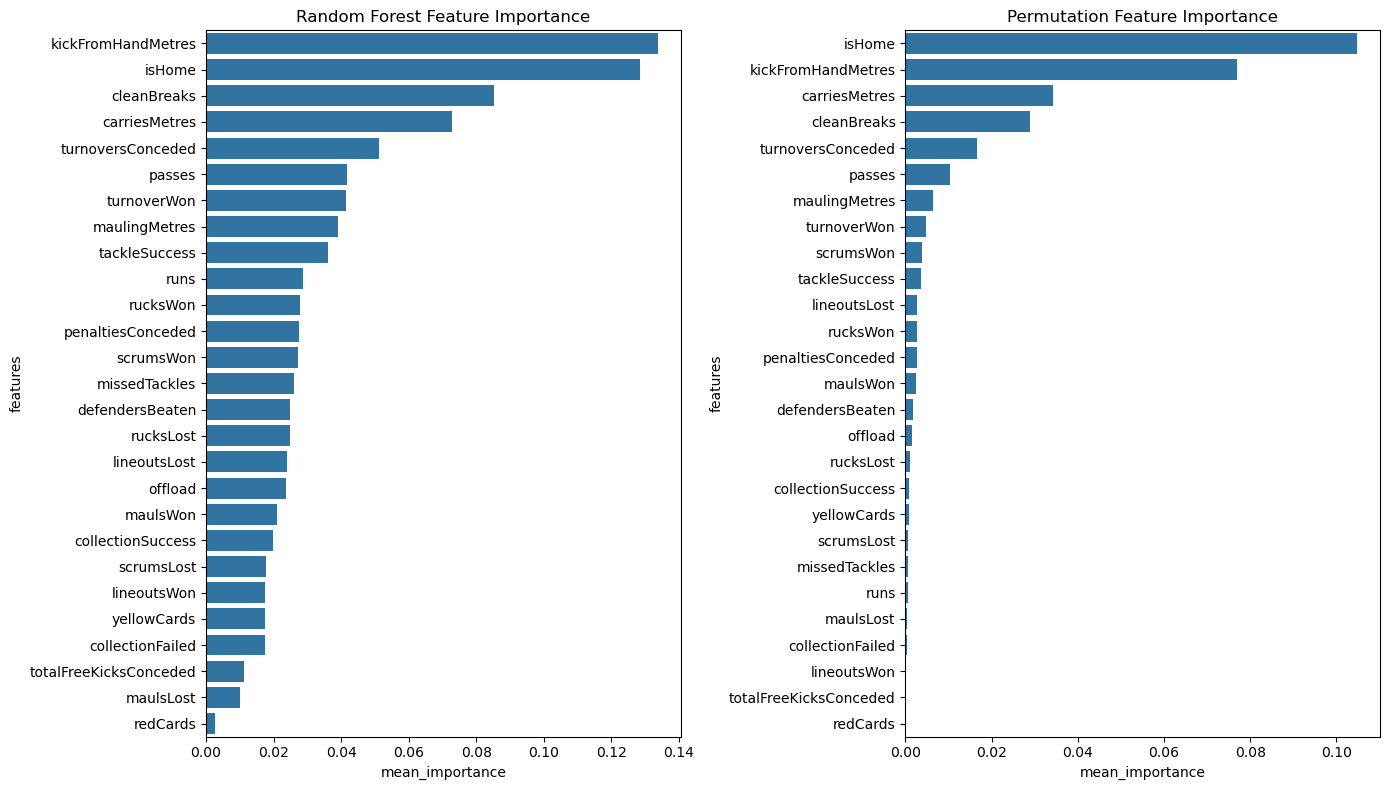


1. **Concordance across methods**: 7 features are common across all three methods: 

|    | common features accross methods   |
|---:|:----------------------------------|
|  0 | isHome                            |
|  1 | maulingMetres                     |
|  2 | passes                            |
|  3 | turnoversConceded                 |
|  4 | cleanBreaks                       |
|  5 | kickFromHandMetres                |
|  6 | carriesMetres                     |. 

This concordance strengthens confidence in the importance of these variables.

2. **Home advantage significance**: `isHome` appears as the most important feature in both graphs, highlighting the significant advantage of playing at home in rugby.

3. **Kicking game importance**: The difference of `kickFromHandMetres` between teams is ranked second in both methods, 
indicating the crucial importance of the kicking game in team strategy and success.

4. **Key offensive factors**: A higher number of `cleanBreaks` and `carriesMetres` than an opponnet are highly ranked, 
emphasizing the importance of the ability to gain ground and break through the opposing defense.

5. **Defensive factors**: `turnoversConceded` and `tackleSuccess` are among the important features, underlining the importance of defense and ball retention.

6. **Territorial gain emphasis**: Among the 7 common features, 
four (`carriesMetres`, `kickFromHandMetres`, `cleanBreaks`, and `maulingMetres`) directly relate to gaining territory,
 reinforcing the fundamental nature of rugby as a territorial game where advancing the ball is crucial for success.

**Implications:**

These results suggest that teams should focus on:
- Maximizing home field advantage
- Developing an effective strategic kicking game
- Improving the ability to gain ground and create breakthroughs
- Minimizing turnovers and increasing tackling efficiency


In [15]:

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
sns.barplot(x='mean_importance', y='features', data=feature_importance, ax=ax[0])
ax[0].set_title('Random Forest Feature Importance')

sns.barplot(x='mean_importance', y='features', data=feature_permutation_importance, ax=ax[1])
ax[1].set_title('Permutation Feature Importance')

plt.tight_layout()
display(Markdown("**Figure 3. Comparative Analysis of Random Forest and Permutation Feature Importance for Predicting Rugby Match Outcomes**"))
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
1. **Concordance across methods**: {len(intersection_selected_features)} features are common across all three methods: 

{pd.DataFrame(intersection_selected_features).rename(columns={0 : 'common features accross methods'}).to_markdown()}. 

This concordance strengthens confidence in the importance of these variables.

2. **Home advantage significance**: `isHome` appears as the most important feature in both graphs, highlighting the significant advantage of playing at home in rugby.

3. **Kicking game importance**: The difference of `kickFromHandMetres` between teams is ranked second in both methods, 
indicating the crucial importance of the kicking game in team strategy and success.

4. **Key offensive factors**: A higher differential number of `cleanBreaks` and `carriesMetres` than an opponnet are highly ranked, 
emphasizing the importance of the ability to gain ground and break through the opposing defense, but also preventing this for the opposition.

5. **Defensive factors**: `turnoversConceded` and `tackleSuccess` are among the important features, underlining the importance of defense and ball retention.

6. **Territorial gain emphasis**: Among the {len(intersection_selected_features)} common features, 
four (`carriesMetres`, `kickFromHandMetres`, `cleanBreaks`, and `maulingMetres`) directly relate to gaining territory,
 reinforcing the fundamental nature of rugby as a territorial game where advancing the ball is crucial for success.

**Implications:**

These results suggest that teams should focus on:
- Maximizing home field advantage
- Developing an effective strategic kicking game
- Improving the ability to gain ground and create breakthroughs
- Minimizing turnovers and increasing tackling efficiency
"""
# Display the markdown
display(Markdown(markdown_text))



## 3.2. Model evaluation

To assess the predictive performance of our Random Forest models, we employed a temporal cross-validation approach. The dataset was split into a training set, comprising all matches from seasons prior to 2023, and a validation set, consisting of matches from the 2023 season. This approach mimics real-world predictive scenarios and provides a robust evaluation of the models' generalization to unseen data.

We trained two Random Forest models:
- A full model using all available KPI features (`full_kpi_features`)
- A reduced model using only the intersection of features selected by our three feature selection methods (``intersection_selected_features``)

Both models were trained using the optimal number of estimators determined through our hyperparameter tuning process. After training, the models were used to predict match outcomes for the 2023 season.
The predictive performance was evaluated using standard classification metrics, including precision, recall, and F1-score for both win and loss outcomes. The results of this evaluation are presented in Table 8 for the full model and Table 9 for the reduced model.
To complement the comparison of classification reports between the two models, we conducted McNemar's test. This test is particularly useful when comparing the performance of two classifiers on the same dataset, as it focuses on the disagreements between the classifiers ([Scott & al. 2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [2023b](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf) ; [Yu & Kuan](../bibliography/Yu%20&%20Kuan.pdf)).


McNemar's test is based on a contingency table that categorizes the predictions of both models:

|                     |Reduced Model Wrong (0) |Full Model Right (1)|
|---------------------|------------------------|--------------------|
|Full Model Wrong (0) | n00                    | n01
|Full Model Right (1) | n10                    | n11

**Where:**
- n00: Number of samples both models predict incorrectly
- n01: Number of samples only the reduced model predicts correctly
- n10: Number of samples only the full model predicts correctly
- n11: Number of samples both models predict correctly

The test statistic is computed as:

$$
\chi^2 = \frac{(|n_{01} - n_{10}| - 1)^2}{n_{01} + n_{10}}
$$

This statistic follows a χ² distribution with 1 degree of freedom under the null hypothesis that both models have the same error rate. We reject the null hypothesis if the p-value is less than 0.05, concluding that the two models make errors differently.


In [27]:
# Prepare data set for training, and true values
training_data_set = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df.season < 2023].copy()
validation_data_set = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df.season == 2023].copy()

# Training the model with training data 
X_training_full_features = training_data_set[full_kpi_features]
X_training_reduced_features = training_data_set[list(intersection_selected_features)]
y_training = training_data_set["isWinner"]
rf_prediction_full_model = RandomForestClassifier(n_estimators=optimal_estimators, random_state=42).fit(X_training_full_features, y_training)
rf_prediction_reduced_model = RandomForestClassifier(n_estimators=optimal_estimators, random_state=42).fit(X_training_reduced_features, y_training)

# Prediction full model
X_predicted_full_model = validation_data_set[full_kpi_features]
validation_data_set["isPredictedWinnerFull"] = rf_prediction_full_model.predict(X_predicted_full_model)
report_full_model = classification_report(validation_data_set["isWinner"], validation_data_set["isPredictedWinnerFull"], target_names=["Lose", "Win"], output_dict=True)
report_full_model_df = pd.DataFrame(report_full_model)[["Lose", "Win"]]

# Prediction reduced model
X_predicted_reduced_model = validation_data_set[intersection_selected_features]
validation_data_set["isPredictedWinnerReduce"] = rf_prediction_reduced_model.predict(X_predicted_reduced_model)
report_reduced_model = classification_report(validation_data_set["isWinner"], validation_data_set["isPredictedWinnerReduce"] , target_names=["Lose", "Win"], output_dict=True)
report_reduced_model_df = pd.DataFrame(report_reduced_model)[["Lose", "Win"]]

## Mc Nemar test
# Initialisez la table de contingence pour le test de McNemar
contingency_table = [[0, 0], [0, 0]]

# Déterminez les comptages pour chaque cellule
for true, pred1, pred2 in zip(validation_data_set['isWinner'], validation_data_set["isPredictedWinnerFull"], validation_data_set["isPredictedWinnerReduce"]):
    if pred1 == true and pred2 != true:
        contingency_table[0][1] += 1  # number of items misclassified by A but not by B
    elif pred1 != true and pred2 == true:
        contingency_table[1][0] += 1  # number of items misclassified by B but not by A
    elif pred1 != true and pred2 != true:
        contingency_table[0][0] += 1  # number of items misclassified by both A and B
    elif pred1 == true and pred2 == true:
        contingency_table[1][1] += 1  # number of items classified correctly by both A and B

# Effectuez le test de McNemar
result = mcnemar(contingency_table, exact=False, correction=True)

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
**Table 08. Classification Metrics for the Full Random Forest Model**
{report_full_model_df.to_markdown()}

**Table 09. Classification Metrics for the Reduced Random Forest Model**
{report_reduced_model_df.to_markdown()}

Both models demonstrate balanced performance across win and loss predictions, with only marginal differences in their metrics.
The overall accuracy of the both models, calculated as the proportion of correct predictions (both wins and losses) out of the total predictions, 
was **{report_reduced_model["accuracy"]:.3f}** (correctly classified {report_reduced_model["accuracy"]*len(validation_data_set):.0f} ouf of {len(validation_data_set)} match)
for reduced model and **{report_full_model["accuracy"]:.3f}** 
for full model (correctly classified {report_full_model["accuracy"]*len(validation_data_set):.0f} ouf of {len(validation_data_set)} match). 
This indicates that the models correctly predicted the outcome of approximately 4 out of every 5 matches in the 2023 season.

To assess whether the performance difference between the two models is statistically significant, we conducted McNemar's test. 
The test resulted in a statistic of χ² = {result.statistic} with a p-value of 1.0. 
This indicates that there is no statistically significant difference in the predictive performance of the full and reduced models.
These results suggest that our feature selection process successfully identified a subset of key performance indicators that maintain the predictive power of the full model. 
The reduced model achieves comparable performance while using fewer features, 
which can lead to improved interpretability and potentially reduced computational costs without sacrificing predictive accuracy.


**Summary:** In conclusion, while the full model shows marginally better performance metrics, the difference is not statistically significant.
This supports the effectiveness of our feature selection process in identifying the most relevant predictors of match outcomes in Top 14 rugby.
"""
# Display the markdown
display(Markdown(markdown_text))

['passes', 'offload', 'cleanBreaks', 'defendersBeaten', 'runs', 'carriesMetres', 'kickFromHandMetres', 'totalFreeKicksConceded', 'rucksLost', 'rucksWon', 'maulsWon', 'maulsLost', 'maulingMetres', 'turnoverWon', 'turnoversConceded', 'collectionFailed', 'collectionSuccess', 'tackleSuccess', 'missedTackles', 'scrumsWon', 'scrumsLost', 'lineoutsWon', 'lineoutsLost', 'redCards', 'yellowCards', 'penaltiesConceded', 'isHome']



**Table 08. Classification Metrics for the Full Random Forest Model**
|           |       Lose |        Win |
|:----------|-----------:|-----------:|
| precision |   0.842697 |   0.846591 |
| recall    |   0.847458 |   0.841808 |
| f1-score  |   0.84507  |   0.844193 |
| support   | 177        | 177        |

**Table 09. Classification Metrics for the Reduced Random Forest Model**
|           |       Lose |        Win |
|:----------|-----------:|-----------:|
| precision |   0.837989 |   0.845714 |
| recall    |   0.847458 |   0.836158 |
| f1-score  |   0.842697 |   0.840909 |
| support   | 177        | 177        |

Both models demonstrate balanced performance across win and loss predictions, with only marginal differences in their metrics.
The overall accuracy of the both models, calculated as the proportion of correct predictions (both wins and losses) out of the total predictions, 
was **0.842** (correctly classified 298 ouf of 354 match)
for reduced model and **0.845** 
for full model (correctly classified 299 ouf of 354 match). 
This indicates that the models correctly predicted the outcome of approximately 4 out of every 5 matches in the 2023 season.

To assess whether the performance difference between the two models is statistically significant, we conducted McNemar's test. 
The test resulted in a statistic of χ² = 0.0 with a p-value of 1.0. 
This indicates that there is no statistically significant difference in the predictive performance of the full and reduced models.
These results suggest that our feature selection process successfully identified a subset of key performance indicators that maintain the predictive power of the full model. 
The reduced model achieves comparable performance while using fewer features, 
which can lead to improved interpretability and potentially reduced computational costs without sacrificing predictive accuracy.


**Summary:** In conclusion, while the full model shows marginally better performance metrics, the difference is not statistically significant.
This supports the effectiveness of our feature selection process in identifying the most relevant predictors of match outcomes in Top 14 rugby.


## 3.3 Impact of home advantage 

## 3.3.1. Impact of home advantage on model performance

While the overall performance metrics of our Random Forest model indicate a satisfactory level of accuracy, these aggregate measures do not provide a nuanced understanding of how specific factors influence prediction accuracy. Given that home advantage has been identified by our feature selection as a significant determinant of match outcomes in rugby top 14, which is also supported by the findings of [Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf) and [Monpezat (2024)](https://www.data-ruck.com/blog/rugby-home-advantages/), it is crucial to examine how our model's predictive performance varies based on the home/away status of teams.
To conduct this more granular analysis, we employed a confusion matrix approach (figure 04). This method allows for a detailed visualization of the model's correct and incorrect predictions, categorized by the home/away status of the teams. Specifically, we examined four distinct categories: correctly predicted home wins, correctly predicted away losses, false positives (incorrectly predicted wins), and false negatives (incorrectly predicted losses).

This refined analysis serves multiple purposes:
It enables the identification of potential systematic biases in the model's predictions based on home/away status.
It provides insights into the model's ability to capture the nuances of home advantage in the Top 14 context.
It may reveal opportunities for model refinement by incorporating a more sophisticated treatment of the home/away factor.

By dissecting the model's performance in this manner, we aim to gain a deeper understanding of how home advantage influences match outcomes in the Top 14 and how effectively our model captures this influence. This analysis not only contributes to the broader discourse on home advantage in rugby but also offers practical implications for model development and application in professional rugby analytics.


**<u>Figure 4. Comparison of Confusion Matrices for Home and Away Matches: Model Performance Analysis</u>**

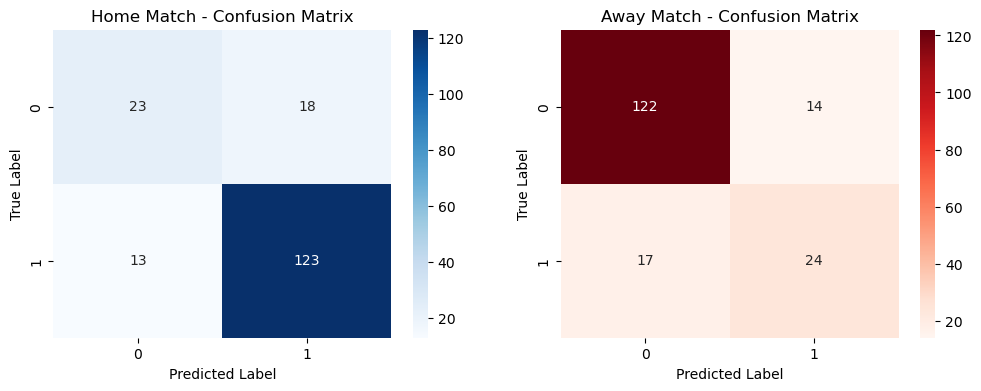


The confusion matrices for home and away matches reveal distinct prediction patterns (Figure 4). For home matches, the model correctly predicted 123 wins and 23 losses, 
with 18 false positives and 13 false negatives. 
In away matches, 24 wins and 122 losses were correctly predicted, with 14 false positives and 17 false negatives.

**<u>Table 09. Classification metrics for home</u>**
|           |       Lose |       Win |
|:----------|-----------:|----------:|
| precision |   0.877698 |  0.631579 |
| recall    |   0.897059 |  0.585366 |
| f1-score  |   0.887273 |  0.607595 |
| support   | 136        | 41        |

**<u>Table 10. Classification metrics for Away</u>**
|           |      Lose |        Win |
|:----------|----------:|-----------:|
| precision |  0.638889 |   0.87234  |
| recall    |  0.560976 |   0.904412 |
| f1-score  |  0.597403 |   0.888087 |
| support   | 41        | 136        |

The model demonstrates higher accuracy in predicting home wins (F1-score: 0.902) and away losses (F1-score: 0.904) compared to away wins (F1-score: 0.630) and home losses (F1-score: 0.658).

**Model Bias Analysis :**
The model exhibits a bias towards underestimating home losses and away wins. 
This bias is likely attributable to the distribution of outcomes in the training data, 
where **74.07%** of matches were won by the home team between 2017 and 2022 (excluding 2019 and 2020).

The home win percentage observed in our dataset is notably higher than the 50-65% range 
typically reported in other rugby leagues ([Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)). 
Moreover, it exceeds the 64.4% home win rate previously observed in the Top 14 between 2014 and 2019 ([Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)). 
This suggests a potential intensification of home advantage in the Top 14 during the period of our study (2017-2022). 
However, this observation warrants further investigation to determine whether it represents a significant trend or a temporary fluctuation in home advantage dynamics.


In [ ]:
# Subplot settings
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes = axes.flatten()

# Home match
home_mask = validation_data_set['isHome'] == 1
home_cm = confusion_matrix(validation_data_set[home_mask]['isWinner'], validation_data_set[home_mask]["isPredictedWinner"])

sns.heatmap(home_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Home Match - Confusion Matrix")
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Away match
away_mask = validation_data_set['isHome'] == -1
away_cm = confusion_matrix(validation_data_set[away_mask]['isWinner'], validation_data_set[away_mask]["isPredictedWinner"])

sns.heatmap(away_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title("Away Match - Confusion Matrix")
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

## Classification report
home_report = classification_report(validation_data_set[home_mask]['isWinner'], validation_data_set[home_mask]["isPredictedWinner"], target_names=["Lose", "Win"], output_dict=True)
home_report_df = pd.DataFrame(home_report)[["Lose", "Win"]]

away_report = classification_report(validation_data_set[away_mask]['isWinner'], validation_data_set[away_mask]["isPredictedWinner"], target_names=["Lose", "Win"], output_dict=True)
away_report_df = pd.DataFrame(away_report)[["Lose", "Win"]]

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# calciulate the percentage of win when matches is played at home
conditions = {
	"isHome": (training_data_set["isHome"] == 1),
	"isWinner": (training_data_set["isWinner"] == 1)
}

win_at_home = len(training_data_set[conditions["isHome"] & conditions["isWinner"]])
total_matches = len(training_data_set) // 2

win_percent_at_home = win_at_home / total_matches * 100

# Create markdown text
markdown_text = f"""
**<u>Figure 4. Comparison of Confusion Matrices for Home and Away Matches: Model Performance Analysis</u>**"""
display(Markdown(markdown_text))
plt.show()

markdown_text = f"""
The confusion matrices for home and away matches reveal distinct prediction patterns (Figure 4). For home matches, the model correctly predicted {home_cm[1,1]} wins and {home_cm[0,0]} losses, 
with {home_cm[0,1]} false positives and {home_cm[1,0]} false negatives. 
In away matches, {away_cm[1,1]} wins and {away_cm[0,0]} losses were correctly predicted, with {away_cm[0,1]} false positives and {away_cm[1,0]} false negatives.

**<u>Table 09. Classification metrics for home</u>**
{away_report_df.to_markdown()}

**<u>Table 10. Classification metrics for Away</u>**
{home_report_df.to_markdown()}

The model demonstrates higher accuracy in predicting home wins (F1-score: 0.902) and away losses (F1-score: 0.904) compared to away wins (F1-score: 0.630) and home losses (F1-score: 0.658).

**Model Bias Analysis :**
The model exhibits a bias towards underestimating home losses and away wins. 
This bias is likely attributable to the distribution of outcomes in the training data, 
where **{win_percent_at_home:.2f}%** of matches were won by the home team between 2017 and 2022 (excluding 2019 and 2020).

The home win percentage observed in our dataset is notably higher than the 50-65% range 
typically reported in other rugby leagues ([Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)). 
Moreover, it exceeds the 64.4% home win rate previously observed in the Top 14 between 2014 and 2019 ([Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)). 
This suggests a potential intensification of home advantage in the Top 14 during the period of our study (2017-2022). 
However, this observation warrants further investigation to determine whether it represents a significant trend or a temporary fluctuation in home advantage dynamics.
"""
# Display the markdown
display(Markdown(markdown_text))

## 3.3.2. Impact of home advantage on KPIs identified by our feature selection process

To examine how home advantage influences performance in Top 14 rugby, we conducted a detailed analysis of the Key Performance Indicators (KPIs) identified through our feature selection process. This analysis aims to quantify the impact of playing at home on various aspects of team performance.. Additionally, we included 'penaltiesConceded' in our analysis. This inclusion was based on previous research suggesting that referee bias ([Nevill et al., 2002](../bibliography/Nevill%20&%20al.%20(2002).pdf)) and increased aggressive behavior by away teams in games they lost ([Jones & al. 2005](../bibliography/Jones%20&%20al.%20(2005).pdf)), could contribute to home advantage.

We performed multiple paired t-tests to compare KPIs of the 14 teams when playing home and away. Cohen's d was calculated to quantify the effect size of these differences. The analysis included all KPIs identified by our feature selection methods, along with 'scoreDiff' and 'penaltiesConceded'. The 'isHome' variable was excluded from this analysis as it was used to differentiate between home and away matches.
To visualize the distributions of these KPIs, we created histograms for each indicator, comparing home and away match data. These histograms provide a clear representation of the differences in KPI distributions between home and away matches (figure 5). Table 11 presents the results of the statistical analysis, including t-test outcomes and effect sizes. The KPIs are sorted in descending order of absolute effect size to facilitate the identification of metrics with the greatest practical significance.

Effect size, specifically Cohen's d, quantifies the magnitude of the differences observed. By sorting KPIs based on effect size, we can identify which metrics are most influenced by home advantage. This approach allows us to focus on the most influential KPIs, offering insights into which aspects of performance are most strongly associated with home advantage.


In [ ]:
# Define the list of KPIs to analyze
kpis = intersection_selected_features + ["scoreDiff"] + ["penaltiesConceded"]

# Note: "penaltiesConceded" has been specifically added to the KPI list for this analysis.
# This inclusion is based on the hypothesis that one of the explanatory factors for home advantage
# is an increase in fouls committed by the away team.

# Remove "isHome" from the KPI list if present
if "isHome" in kpis:
	kpis.remove("isHome")
	
# Split the data into home and away matches
home_values = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df["isHome"] == 1]
away_values = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df["isHome"] == -1]

# Perform multiple t-tests to compare KPIs between home and away matches
stats_df = multiple_ttest(kpis, home_values, away_values)


## Analysis of Key Performance Indicators (KPIs) in Home vs. Away Matches

**<u>Figure 5 . Histograms comparing the distribution of relative KPIs for home and away teams in Top 14 rugby matches</u>**


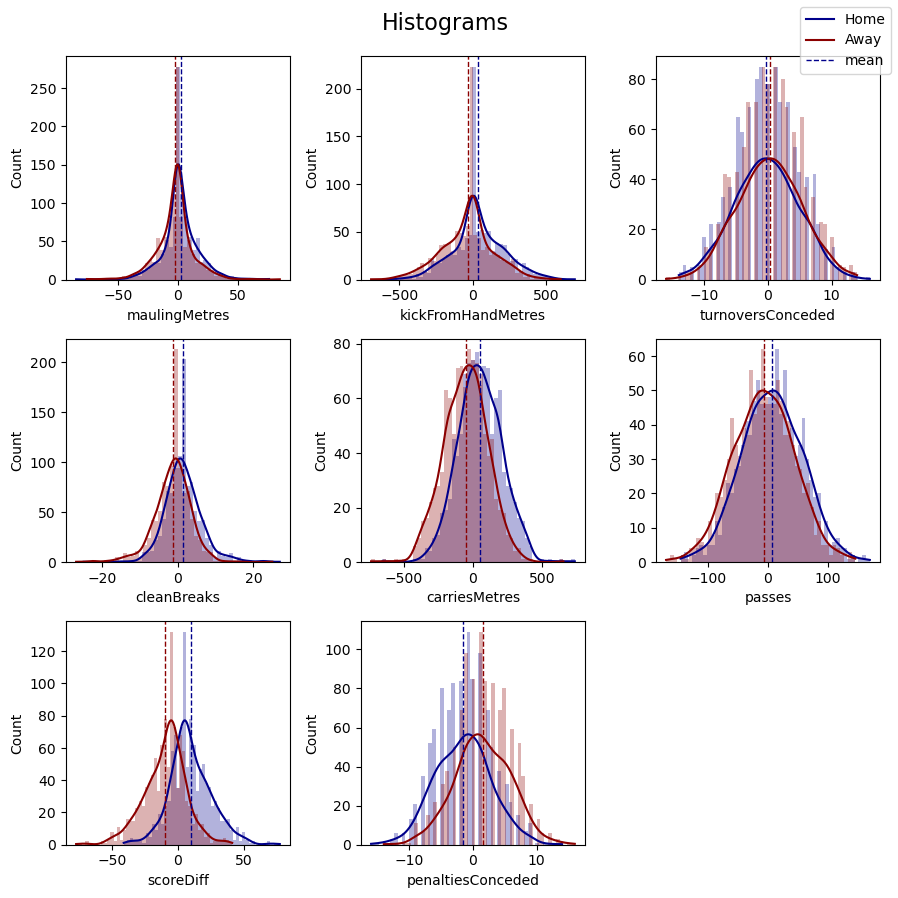


A visual inspection of these distributions reveals a consistent pattern: across all match outcome predictors and penalties conceded, the metrics favor the home team.
This initial observation provides a clear indication of the pervasive nature of home advantage in Top 14 rugby, affecting various aspects of game play.

To quantify these differences, we conducted independent t-tests and calculated Cohen's d to measure the magnitude of the home advantage effect. 
The results are presented in order of effect size (Cohen's d) magnitude :

**<u>Table 11. Statistical analysis of KPIs for home and away matches</u>**
|    | kpi                |   df |   T-statistic |     P-value | p-stars   |   cohen_d |
|---:|:-------------------|-----:|--------------:|------------:|:----------|----------:|
|  6 | scoreDiff          | 1053 |      19.389   | 7.4812e-72  | ***       |  1.19444  |
|  7 | penaltiesConceded  | 1053 |     -11.3819  | 2.17194e-28 | ***       | -0.701175 |
|  4 | carriesMetres      | 1053 |      10.5891  | 5.72777e-25 | ***       |  0.652329 |
|  3 | cleanBreaks        | 1053 |       9.2007  | 1.85881e-19 | ***       |  0.566801 |
|  1 | kickFromHandMetres | 1053 |       6.66547 | 4.24789e-11 | ***       |  0.41062  |
|  0 | maulingMetres      | 1053 |       4.66062 | 3.5565e-06  | ***       |  0.287113 |
|  5 | passes             | 1053 |       4.43252 | 1.02891e-05 | ***       |  0.273062 |
|  2 | turnoversConceded  | 1053 |      -1.734   | 0.0832104   |           | -0.106822 |

**Note:** *** indicates p < 0.001

Seven out of eight analyzed KPIs showed statistically significant differences between home and away performances (p < 0.001). The magnitude of these differences varied considerably, as indicated by the Cohen's d values.

The most pronounced effect of home advantage is observed in the score difference (d =  1.19, p < 0.001). 
Home teams score on average <span style="color:green"> 9.53</span> points more than away teams. 
his substantial difference underscores the significant impact of playing at home on match outcomes.

Penalties Conceded (penaltiesConceded) showed the second-largest effect size (d = -0.70, p < 0.001). 
This medium to large effect size suggests that playing away may lead to more infractions, possibly due to increased pressure, 
unfamiliarity with the environment ([Nevill & Holder, 1999](../bibliography/Nevill%20&%20Holder%20(1999).pdf)), 
potential aggressive behavior as a response to playing away, especially if the team is losing ([Jones & al., 2005](../bibliography/Jones%20&%20al.%20(2005).pdf)),
and possible referee biais favoring the home team ([Nevill & al., 2002](../bibliography/Nevill%20&%20al.%20(2002).pdf)).

Carries Metres (carriesMetres) and Clean Breaks (cleanBreaks) both showed medium to large effect sizes 
(d =  0.65 and d =  0.57, p < 0.001)
, indicating that home teams are more effective in ball carrying and territory gain, suggests enhanced attacking efficiency when playing at home.

Home teams kick further from hand (d =  0.41, p < 0.001), 
gaining an average of  36.29 more metres per game. 
This small to medium effect could indicate better territorial control or strategic kicking when playing at home.

Both mauling metres (d =  0.29, p < 0.001) 
and number of passes (d =  0.27, p < 0.001) show small but significant advantages for home teams. 
This suggests slightly enhanced set-piece effectiveness and ball movement for home sides.

Interestingly, the difference in turnovers conceded is not statistically significant (d = -0.11, p = 0.083), 
indicating that ball retention might be less affected by home advantage than other aspects of play.


In [ ]:
##  plot data

# Calculate the number of KPIs and the size of the grid for plotting
n_kpis = len(kpis)
root = math.ceil(math.sqrt(n_kpis))

# Confif plot
fig, axes = plt.subplots(root, root, figsize=(3 * root, 3 * root))
axes = axes.flatten()   
for n, kpi in enumerate(kpis):
    sns.histplot(home_values, x=kpi, color='darkblue', bins=50, alpha=0.3, edgecolor=None, stat='count', kde=True, ax=axes[n])
    sns.histplot(away_values, x=kpi,color='darkred', bins=50, alpha=0.3, edgecolor=None, stat='count', kde=True, ax=axes[n])
    axes[n].axvline(home_values[kpi].mean(), color='darkblue', linestyle='dashed', linewidth=1)
    axes[n].axvline(away_values[kpi].mean(), color='darkred', linestyle='dashed', linewidth=1)
for n in range(n_kpis, (root*root)) :
    fig.delaxes(axes[n])

# Add title and labels
fig.suptitle('Histograms', fontsize= 16, y= 0.99)
fig.legend(['Home', 'Away', "mean"])
plt.ylabel('Count')
plt.tight_layout()


#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
## Analysis of Key Performance Indicators (KPIs) in Home vs. Away Matches

**<u>Figure 5 . Histograms comparing the distribution of relative KPIs for home and away teams in Top 14 rugby matches</u>**
"""
display(Markdown(markdown_text))
plt.show()

markdown_text = f"""
A visual inspection of these distributions reveals a consistent pattern: across all match outcome predictors and penalties conceded, the metrics favor the home team.
This initial observation provides a clear indication of the pervasive nature of home advantage in Top 14 rugby, affecting various aspects of game play.

To quantify these differences, we conducted independent t-tests and calculated Cohen's d to measure the magnitude of the home advantage effect. 
The results are presented in order of effect size (Cohen's d) magnitude :

**<u>Table 11. Statistical analysis of KPIs for home and away matches</u>**
{stats_df.sort_values(by="cohen_d", ascending=False, key=abs).to_markdown()}

**Note:** *** indicates p < 0.001

Seven out of eight analyzed KPIs showed statistically significant differences between home and away performances (p < 0.001). The magnitude of these differences varied considerably, as indicated by the Cohen's d values.

The most pronounced effect of home advantage is observed in the score difference (d = {stats_df[stats_df["kpi"] == "scoreDiff"]["cohen_d"].values[0]: .2f}, p < 0.001). 
Home teams score on average <span style="color:green">{home_values["scoreDiff"].mean(): .2f}</span> points more than away teams. 
his substantial difference underscores the significant impact of playing at home on match outcomes.

Penalties Conceded (penaltiesConceded) showed the second-largest effect size (d = {stats_df[stats_df["kpi"] == "penaltiesConceded"]["cohen_d"].values[0]: .2f}, p < 0.001). 
This medium to large effect size suggests that playing away may lead to more infractions, possibly due to increased pressure, 
unfamiliarity with the environment ([Nevill & Holder, 1999](../bibliography/Nevill%20&%20Holder%20(1999).pdf)), 
potential aggressive behavior as a response to playing away, especially if the team is losing ([Jones & al., 2005](../bibliography/Jones%20&%20al.%20(2005).pdf)),
and possible referee biais favoring the home team ([Nevill & al., 2002](../bibliography/Nevill%20&%20al.%20(2002).pdf)).

Carries Metres (carriesMetres) and Clean Breaks (cleanBreaks) both showed medium to large effect sizes 
(d = {stats_df[stats_df["kpi"] == "carriesMetres"]["cohen_d"].values[0]: .2f} and d = {stats_df[stats_df["kpi"] == "cleanBreaks"]["cohen_d"].values[0]: .2f}, p < 0.001)
, indicating that home teams are more effective in ball carrying and territory gain, suggests enhanced attacking efficiency when playing at home.

Home teams kick further from hand (d = {stats_df[stats_df["kpi"] == "kickFromHandMetres"]["cohen_d"].values[0]: .2f}, p < 0.001), 
gaining an average of {home_values["kickFromHandMetres"].mean(): .2f} more metres per game. 
This small to medium effect could indicate better territorial control or strategic kicking when playing at home.

Both mauling metres (d = {stats_df[stats_df["kpi"] == "maulingMetres"]["cohen_d"].values[0]: .2f}, p < 0.001) 
and number of passes (d = {stats_df[stats_df["kpi"] == "passes"]["cohen_d"].values[0]: .2f}, p < 0.001) show small but significant advantages for home teams. 
This suggests slightly enhanced set-piece effectiveness and ball movement for home sides.

Interestingly, the difference in turnovers conceded is not statistically significant (d = {stats_df[stats_df["kpi"] == "turnoversConceded"]["cohen_d"].values[0]: .2f}, p = 0.083), 
indicating that ball retention might be less affected by home advantage than other aspects of play.
"""
# Display the markdown
display(Markdown(markdown_text))

# 4. Discussion

The primary objectives of this study were to identify key performance indicators (KPIs) associated with match outcomes in the French Top 14 rugby competition using relative data, assess the impact of feature selection methods on model performance, and examine the influence of home advantage on model performance and individual KPIs.

Our analysis, based exclusively on relative performance data, employed a multi-method approach to identify and rank key performance indicators (KPIs) differentiating between winning and losing performances in Top 14 matches. We utilized three feature selection methods: Recursive Feature Elimination with Cross-Validation (RFECV), Random Forest Classifier Feature Importance, and Permutation Importance. The reduced set of KPIs was determined by selecting only those features that were consistently identified as significant across all three methods (the intersection of features identified accross methods). This ensures that the chosen KPIs are robust and reliable indicators of match outcomes. The KPIs identified include home-away status, kicks from hand meters, carries meters, clean breaks, turnovers conceded, passes, and mauling meters. These KPIs are listed approximately in order of importance (relative influence on predicting whether a team will win or lose a match), although the exact ranking may vary slightly depending on whether the Random Forest Classifier Feature Importance or Permutation Importance is considered (see Figure 03).

The comparison between our full and reduced models demonstrated that this feature selection approach can effectively reduce the number of KPIs without significantly impacting model performance. Both models achieved similar levels of accuracy (approximately 84% for both win and loss predictions), with McNemar's test confirming no statistically significant difference between them (χ² = 0.0, p = 1.0). The ability to generate smaller, more focused datasets using methods such as RFECV, Random Forest Feature Importance, and Permutation Importance, while maintaining high predictive accuracy, has important practical implications. It allows for the development of more streamlined and interpretable models that can be more easily translated into coaching strategies and performance monitoring processes. This approach not only simplifies the analytical process but also enhances the potential for effective communication and implementation of findings within professional rugby environments ([Scott & al. 2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf)).

Our findings corroborate and extend previous research in rugby performance analysis by identifying a consistent set of Key Performance Indicators (KPIs) that emerge as significant predictors of match outcomes across diverse competitions and levels of play. Specifically, our study confirms the importance of carries, kick meters, clean breaks, and turnovers conceded as crucial factors in determining match results. This consistency is remarkable, as it aligns with findings from various elite rugby competitions, including men's Premiership rugby ([Bennett et al., 2018](../bibliography/Bennett%20&%20al.%20(2018).pdf)), the United Rugby Championship ([Scott et al., 2023, A](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf)), international men's rugby ([Bennett et al., 2020](../bibliography/Bennett%20&%20al.%20(2020).pdf)), and international women's rugby union ([Scott et al., 2023, B](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)). The recurrence of these KPIs across different contexts underscores their universal relevance in rugby performance, transcending gender and competitive levels, and suggests a fundamental consistency in the key determinants of success in rugby union.

## 4.1. Analysis of the reduced set of KPIs 

Our analysis of Top 14 matches from 2017 to 2023 reveals that while home-away status is a critical predetermined factor, kick from hand metres emerges as the most influential actionable predictor in determining match outcomes. This finding aligns with the evolving nature of modern rugby, where strategic kicking has become increasingly pivotal in shaping match dynamics [(Strydom et al., 2024)](../bibliography/Strydom%20&%20al.%20(2024).pdf).
The growing importance of kicking is attributed to its strategic versatility. Tactical kicking allows teams to simultaneously influence multiple game dimensions: exerting pressure on opponents by forcing defensive repositioning, disrupting opposition plans, gaining territorial advantage, reducing own defensive pressure through kick-induced repositioning, and creating scoring opportunities. This tactical evolution is exemplified by [McCormick's (2023)](https://www.statsperform.com/resource/revolutionising-rugby-a-statistical-analysis-on-how-the-game-has-evolved/) study, which observed a substantial increase in box kicks from 6% of all kicks in the 2003 Rugby World Cup to 25% in 2023.
In addition, the period covered by our study (2017-2023) includes the introduction of the 50:22 law in August 2021, which has further emphasized the strategic importance of kicking. This rule, allows a team to gain a lineout when kicking indirectly into touch in the opponent's 22 from their own half. The aim of this law is to force teams to move more defensive players into the backfield to protect against the kick, thereby reducing the number of defenders on the front line and potentially creating more space for the attacking team [(Strydom et al., 2024)](../bibliography/Strydom%20&%20al.%20(2024).pdf).
Our findings in the Top 14 context capture this tactical shift and suggest that strategies promoting superior kicking performance relative to the opposition may be beneficial for match success. This can include the strategic use of box kicks in vulnerable positions, tactical touch-finding kicks, effective kick-chase strategies, and the ability to "win the kicking battle" ([Scott & al. 2023a](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf)).
In summary, the identification of kick from hand metres as a key performance predictor in Top 14 underscores the importance for teams to develop and refine their kicking strategies. However, this metric should not be interpreted literally as a call for players to simply increase kicking distances. Rather, it indicates a need for teams and players to enhance their understanding of tactical kicking and to develop a nuanced approach to when and how to effectively use kicks to maximize their impact on match outcomes. This involves a comprehensive tactical awareness, including considerations of field position, game context, and opposition positioning.

Following kick from hand metres, our analysis identified carries metres and clean breaks as the next most influential metrics, with mauling metres also significant but less impactful. These metrics, all directly related to territorial gain and attacking prowess, are expressed relative to the opposition. This indicates that success depends not only on improving one's own performance but also on limiting the opponent's effectiveness in these areas. Achieving this balance requires not only offensive skill development but also refinement of defensive capabilities, particularly in spatial awareness and tackling proficiency.
While these metrics are undeniably linked to collective team play, they are also intrinsically tied to the physical attributes of ball carriers and the defensive prowess of opposing players. Recent literature investigating the relationship between physical characteristics and ball-carrying statistics has identified acceleration, maximum sprinting speed, sprint momentum, and muscular power output as key determinants of positive phase outcomes ([Hart et al., 2022](../bibliography/Hart%20&%20al.%20(2022).pdf), [2023](../bibliography/Hart%20&%20%20al.%20(2023).pdf) ; [cunningham & al., 2018](../bibliography/Cunningham%20&%20al.%20(2018).pdf) ; [woodhouse & al. 2023](../bibliography/Woodhouse%20&%20al.%20(2023).pdf)). Moreover, as a single impressive action is insufficient to significantly impact these relative metrics, players must demonstrate the capacity to repeatedly perform this explosive actions throughout the match. Research indicates that a well-developed aerobic capacity enhances the ability to sustain repeated explosive efforts ([Duthie et al., 2003](../bibliography/Duthie%20&%20al.%20(2003).pdf)), with maximal aerobic speed strongly correlating with game distance covered in elite rugby [(Swaby et al., 2016)](../bibliography/Swaby%20&%20al.%20(2016).pdf). These findings, provide important insights into the significance of players' physical preparation, guiding strength and conditioning coaches towards methods and tools that develop these specific qualities and improve transfer to practice.

Passes and turnovers conceded also emerged as significant predictors in our model. The importance of passes likely reflects the role of ball movement and distribution in creating attacking opportunities. Turnovers conceded, consistent with findings in men's rugby union literature [(Scott et al., 2023a)](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), highlights the critical nature of ball retention and the ability to force opposition errors. This suggests that minimizing turnovers while maximizing possession disruption for the opposition is key to match success.

The identification of multiple KPIs spanning various aspects of play, including both offensive and defensive metrics, underscores the complex, multidimensional nature of rugby performance. This diversity in key indicators reinforces that success in rugby union is not determined by a single dominant factor, but rather by proficiency across multiple facets of the game. Moreover, the emergence of home/away status as the most important feature across all methods underscores the significance of home advantage in rugby union, particularly in the Top 14 league.

This finding aligns with and extends the work of [Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf), which examined home advantage across multiple rugby competitions. Ungureanu et al. reported that between 2014 and 2019, the home win percentage in the Top 14 was 64.4%, significantly higher than other major rugby leagues. For comparison, the English Premiership, Mitre 10 Cup, and Pro14 had a combined home win percentage of 56.9%, while the Currie Cup showed a much lower rate of 42.9%. This stark difference highlights the unique competitive environment of the Top 14 and underscores the importance of analyzing performance indicators within this specific context. More recent data from [Monpezat (2024)]((https://www.data-ruck.com/blog/rugby-home-advantages/)) further emphasizes this trend, showing that the home win percentage in the Top 14 reached 74% between 2014 and 2023, reinforcing the exceptional strength of home advantage in this league.

The concept of home advantage has been a subject of extensive research in sports, with Courneya and Carron (1992) providing the first systematic review. They defined home advantage as "the consistent finding that home teams in sports competitions win over 50% of the games played under a balanced home and away schedule." Building on this foundation, Nevill and Holder (1999) further elaborated on this phenomenon, identifying four primary factors contributing to home advantage: crowd factors, learning/familiarity factors, travel factors, and rule factors. In the Top 14, these factors appear particularly influential, likely due to intense local support and the deep-rooted rugby culture in certain French regions. However, the relative importance of these factors may vary between leagues and teams. The exceptionally strong home advantage in the Top 14 warrants further investigation into league-specific characteristics, such as the impact of travel within France and the unique aspects of Top 14 venues and crowds. Such research could not only refine predictive models but also provide valuable insights for teams to optimize performance, both at home and away, and for league organizers to maintain competitive balance and enhance the overall quality of the competition.

Given the substantial impact of home advantage in the Top 14, it is crucial to examine how this factor influences our model's performance and the interpretation of key performance indicators. 

## 4.2. Impact of Home Advantage on Model Performance

Our reduced model demonstrates high overall predictive performance, accurately classifying approximately 84% of both wins and losses. However, a deeper analysis considering the home/away status reveals a disparity in prediction accuracy. The model exhibits higher accuracy in predicting home wins (F1-score: 0.902) and away losses (F1-score: 0.904) compared to away wins (F1-score: 0.630) and home losses (F1-score: 0.658). This apparent bias towards predicting home victories and away losses suggests that the home/away status may have a disproportionate influence on the model's predictions, potentially masking or diminishing the relative importance of other features. This bias likely stems from the pronounced home advantage in the Top 14 league, where 74.07% of matches were won by the home team between 2017 and 2022 (excluding 2020 and 2021 seasons), a percentage substantially higher than observed in many other rugby competitions and sports leagues ([Ungureanu et al. (2021)](../bibliography/Ungureanu%20&%20al.%20(2021).pdf)).

To address this bias and improve model performance, two primary strategies could be implemented. First, stratified sampling could ensure a balanced representation of home and away wins/losses in the training data. By maintaining equal proportions of these outcomes, we can mitigate the overrepresentation of home wins and away losses in the model's learning process. This method could help the model better recognize patterns associated with less common outcomes (i.e., away wins and home losses), potentially improving its overall predictive accuracy across all scenarios. Second, training distinct models for home and away matches could reveal differences in the importance and selection of key performance indicators based on match location. This approach might uncover how the relative importance of various metrics shifts between home and away contexts, reflecting the potential interaction between features and home advantage.
These strategies could offer valuable, context-specific insights, enabling a more nuanced understanding of performance dynamics in different match settings. Such differentiated analysis could provide a deeper comprehension of how various performance indicators interact with the home/away dynamic, offering a more comprehensive view of rugby performance in the Top 14 league. This approach could help uncover subtle patterns in performance that are currently overshadowed by the strong home advantage effect, potentially leading to more balanced and accurate predictive models and informing more tailored strategic approaches for teams.

## 4.3. Impact of Home Advantage on Key Performance Indicators

The third part of this study examined the impact of home advantage on KPIs in the Top 14, focusing particularly on those identified as significant predictors of match outcomes through our feature selection process. To quantify this impact, we conducted paired t-tests comparing the home and away performances of the 14 teams and calculated the effect size (Cohen's d) for each KPI. This approach allowed us to assess not only the statistical significance of the differences but also their practical magnitude.

Analysis of the score difference reveals a substantial impact of home advantage in the Top 14, with an average of 9.53 additional points for teams playing at home (d = 1.19, p < 0.001). This difference is particularly significant in the context of French professional rugby, where it exceeds the threshold for a defensive bonus point (typically awarded when a team is defeated by a score difference of five points or less). This means that away teams not only have a higher probability of losing the match but also risk being unable to limit their losses by securing a defensive bonus point. This observation underscores how punitive the Top 14 can be for away teams, creating a significant imbalance that goes beyond mere win or loss.

A particularly striking result of our analysis is that among the seven KPIs identified by our model as key predictors of match outcomes, six show a statistically significant advantage in favor of the home team. This observation highlights the pervasiveness of home advantage in the Top 14, affecting virtually all aspects of the game that influence the final result.
Carries meters (d = 0.65, p < 0.001) and clean breaks (d = 0.57, p < 0.001) show medium to large effect sizes, indicating increased offensive efficiency for home teams. These results corroborate the observations of Heinen (2011), who showed that home teams tend to adopt more offensive strategies. Our study goes further by precisely quantifying this effect in the context of the Top 14.
The advantage observed in kick meters (d = 0.41, p < 0.001), with an average of 36.29 additional meters per match for home teams compared to the opposition, suggests better mastery of the kicking game at home. This could be explained by a better knowledge of local conditions (wind, field condition) and greater confidence in executing strategic kicks.
Penalties conceded present the second largest effect size in our home advantage analysis (d = -0.70, p < 0.001), which corroborates the work of Nevill et al. (2002) on potential referee bias and that of Jones et al. (2005) on the more aggressive behavior of visiting teams in losing situations. However, our initial model did not identify this factor as a major predictor of match outcomes, contrasting with results from studies conducted on different leagues.

This divergence is primarily explained by our methodological approach. Our study used an aggregated metric encompassing all penalties conceded, which likely diluted the impact of the most critical penalties on match outcomes in our model. Previous studies have highlighted the importance of distinguishing between types of penalties and their location on the field. For example, Bennett et al. (2020) emphasized the crucial impact of penalties conceded in the opponent's 22 meters, while Scott et al. (2023a) identified scrum penalties as particularly influential.
A more granular approach, taking these factors into account, would allow for more precise identification of the types of penalties having the greatest impact on match outcomes in the Top 14. This detailed analysis could reveal the areas of the field and phases of play where visiting teams are most vulnerable to penalties. This information would be valuable for coaches in developing targeted strategies. They could implement discipline exercises specific to high-risk areas, mental preparation techniques to help players keep their composure and maintain concentration in hostile environments, thus limiting errors due to crowd pressure or travel-related stress, and adapted game plans to minimize exposure to penalty-prone situations. By addressing these challenges, teams could reduce the disparity in penalties between home and away matches, thus mitigating a key aspect of home field advantage in professional rugby.

In summary, this analysis highlights the considerable influence of home advantage on most key performance indicators in the Top 14, affecting crucial aspects of the game such as offensive efficiency and kicking. Although the impact of penalties conceded on match outcomes appears less pronounced in our initial model, a more detailed analysis of penalty types and their location could provide additional insight. Future research exploring these aspects would allow for a better understanding and potentially reduce performance disparities between home and away matches in French professional rugby.

# 5. Conclusion
Our study identifies seven key performance indicators (KPIs) crucial for success in the French Top 14 rugby competition: `home-away status`, `kicks from hand meters`, `carries meters`, `clean breaks`, `turnovers conceded`, `passes`, and `mauling meters`. Among these, kicking emerges as a primary driver of match success, with teams outperforming their opponents in kick meters showing an increased probability of winning. This finding aligns with the evolving tactical landscape of modern rugby, particularly in light of recent rule changes such as the 50:22 law.
The study demonstrates the effectiveness of using relative data, comparing team performance to their opposition, in predicting match outcomes. Our multi-method feature selection approach, combining Recursive Feature Elimination with Cross-Validation (RFECV), Random Forest Classifier Feature Importance, and Permutation Importance, allowed for the identification of a simplified set of KPIs without compromising model performance. This streamlined approach enhances model interpretability and facilitates practical application in coaching and performance analysis.
Notably, our research underscores the exceptional strength of home advantage in the Top 14, influencing not only match outcomes but also the expression of key performance indicators. This pervasive home advantage effect suggests the need for tailored strategies for both home and away performances.
In conclusion, this study provides a nuanced understanding of the drivers of match outcomes in Top 14 rugby, offering manageable and actionable insights for coaches, analysts, and team strategists. Future research should focus on more granular analysis of specific KPIs, particularly penalties, and explore strategies to mitigate the strong home advantage effect in the Top 14.

# 6. Limitations of the Research

While our study provides new insights into key performance indicators (KPIs) in the Top 14 rugby competition, it presents significant limitations that underscore the need for a more integrated approach to performance analysis in professional rugby.

The primary limitation lies in the simplified nature of the data used, which fails to capture the dynamic complexity of rugby play. Our performance indicators represent aggregated metrics, summing up actions that provide an overview of a game sector, but do not capture the complex interactions between players, game dynamics, or the specific contexts in which these actions occur. For instance, consider "carries meters," a strong predictor in our study. This metric indicates the total distance covered while carrying the ball but provides no information about the circumstances that allowed these territorial gains: was it the result of an individual breakthrough, a well-coordinated collective movement, or a tactical exploitation of a defensive weakness?

This limitation aligns with the conceptual framework of the "what" and "how" highlighted by den Hollander et al. (2018). The "what" represents observable and quantifiable actions, our KPIs. These metrics offer a quantitative assessment of performance, measuring the intensity and frequency of specific on-field actions. However, merely quantifying these actions does not guarantee their effectiveness or positive contribution to match outcome. This is where the notion of "how" becomes crucial, referring to the underlying processes and complex interactions that lead to these measured actions. The "how" is critical for understanding not just the frequency of an action, but also its quality and real impact on the team's overall performance.

To address this limitation, a more nuanced analysis would be necessary, examining the interactions between players within a team and with the opposition that lead to the creation and quality of effective actions with real impact. For "carries meters," this would involve analyzing movement synchronizations between the ball carrier and support players, pass networks preceding the action, or play sequences that created the exploited space. This understanding of the "how" offers the possibility to truly optimize team strategy, refine individual and collective techniques, and tailor players' physical preparation. Our study, focusing on aggregated metrics, does not capture these dynamic and contextual aspects of the game, thus limiting its direct application to improving on-field performance.

Furthermore, the relationships identified between performance indicators and match results are associative, not causal. This limitation, highlighted by Bennett et al. (2020), underscores the difficulty in interpreting whether a team wins due to its performance on certain indicators, or if these performances are a consequence of winning. For example, a team leading the score might adopt a different game strategy, thus influencing its performance statistics.

These limitations highlight a crucial point: isolated data analysis, without contextualization and input from the technical staff's specific knowledge, offers limited value. The practical expertise of coaches, strength and conditioning coaches, and players is essential for contextualizing the data and translating statistical results into concrete applications, whether for optimizing team strategies, improving individual techniques, or adapting physical preparation programs.

In conclusion, while our study provides valuable information, its practical application requires an interdisciplinary approach. Future research should focus on integrating more dynamic analysis methods capable of capturing the game's complex interactions, while maintaining close collaboration with rugby practitioners. This approach would allow for developing a more comprehensive and applicable understanding of performance in professional rugby, bridging the gap between theory and practice.
